## @Authored By Hamza Kacem
#### Contact me on:
 - [**LinkedIn**](https://www.linkedin.com/in/hamza-kacem-01920018b/)<br>
 - [**Xing**](https://www.xing.com/profile/Hamza_Kacem4/cv)<br>
 - **Email**: kacem02@ads.uni-passau.de

Given a dataset of two-digit handwritten numbers. The goal is to design and train a classifier that can predict the number from the input image.<br>
In this notebook I trained a deep learning model (similar to RESNET ) along with an SVC classifier(used as a baseline classifier), inspected how both performed on the provided image dataset and finally compared the outcomes.

In [1]:
# !pip install -U tensorflow==2.8
# !pip install -U gdown

### Download & Unzip Data

In [2]:
# !gdown --fuzzy "https://drive.google.com/file/d/1itN-8u15tC-45jy7ff7bAx9DujjEQ36n/view?usp=sharing" \
#  && unzip -qq images.zip -d data \
#  && rm images.zip

### Imports

In [3]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.random.set_seed(1234)
np.random.seed(1234)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from library.visualize import acc_loss_plot, plot_mnist_images, plot_cm
from library.model import ResNetLike
from library.utils import rename_image_2_digit, create_sklearn_data
from sklearn.metrics import classification_report
from sklearn.svm import SVC

## Parameters

In [4]:
IMG_SHAPE = (45, 45)
EPOCHS = 50
BATCH_SIZE = 128
TRAINING_DIR = './data/images/train/'
TEST_DIR = './data/images/test/'

## Data Preprocessing

In [5]:
rename_image_2_digit(TRAINING_DIR)
rename_image_2_digit(TEST_DIR)

####  Data Augmentation with Keras ImageDataGenerator 

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    data_format='channels_last',
    fill_mode='nearest',
)

In [7]:
#Creating our batch of one image for models evaluation
eval_generator_one = datagen.flow_from_directory( 
    TEST_DIR,
    target_size=IMG_SHAPE,
    batch_size =1,
    color_mode="grayscale",
    class_mode="sparse",
    shuffle=True,
    seed=1234,
)

Found 1000 images belonging to 100 classes.


## Sklearn Classifier

In [8]:
svm_train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=IMG_SHAPE,
    batch_size=1,
    color_mode="grayscale",
    class_mode="sparse",
    shuffle=False,
)

Found 10000 images belonging to 100 classes.


In [9]:
svm_test_generator = datagen.flow_from_directory( 
    TEST_DIR,
    target_size=IMG_SHAPE,
    batch_size=1,
    color_mode="grayscale",
    class_mode="sparse",
    shuffle=False,
)

Found 1000 images belonging to 100 classes.


In [10]:
X_train, y_train = create_sklearn_data(svm_train_generator)
X_test, y_test = create_sklearn_data(svm_test_generator)

In [11]:
clf = SVC(gamma=0.001)
clf.fit(X_train, y_train);

In [12]:
y_hat = clf.predict(X_test)

In [13]:
print(classification_report(svm_test_generator.classes, y_hat))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.82      0.78      0.80        18
           2       0.90      0.53      0.67        17
           3       0.29      0.33      0.31         6
           4       0.86      0.50      0.63        12
           5       0.56      0.62      0.59         8
           6       0.71      0.62      0.67         8
           7       0.62      0.71      0.67         7
           8       0.50      0.70      0.58        10
           9       0.67      0.67      0.67         3
          10       0.60      0.82      0.69        11
          11       0.47      0.78      0.58         9
          12       0.92      0.69      0.79        16
          13       0.62      1.00      0.76         8
          14       0.38      0.43      0.40         7
          15       0.63      0.80      0.71        15
          16       0.65      0.92      0.76        12
          17       0.62    

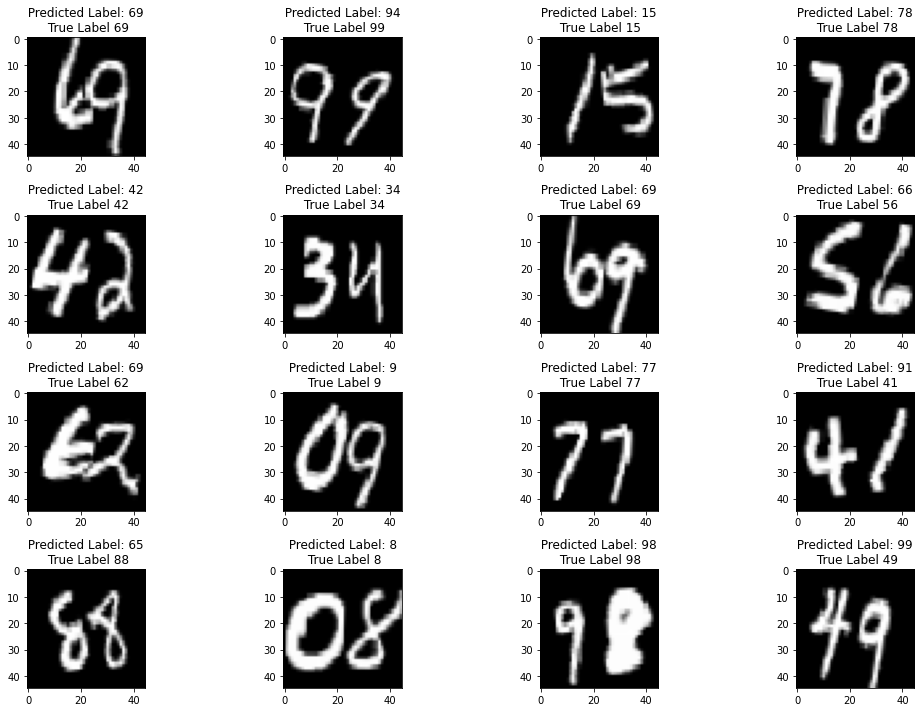

In [14]:
plot_mnist_images(eval_generator_one, clf, row=4, col=4, sklearn_model=True)

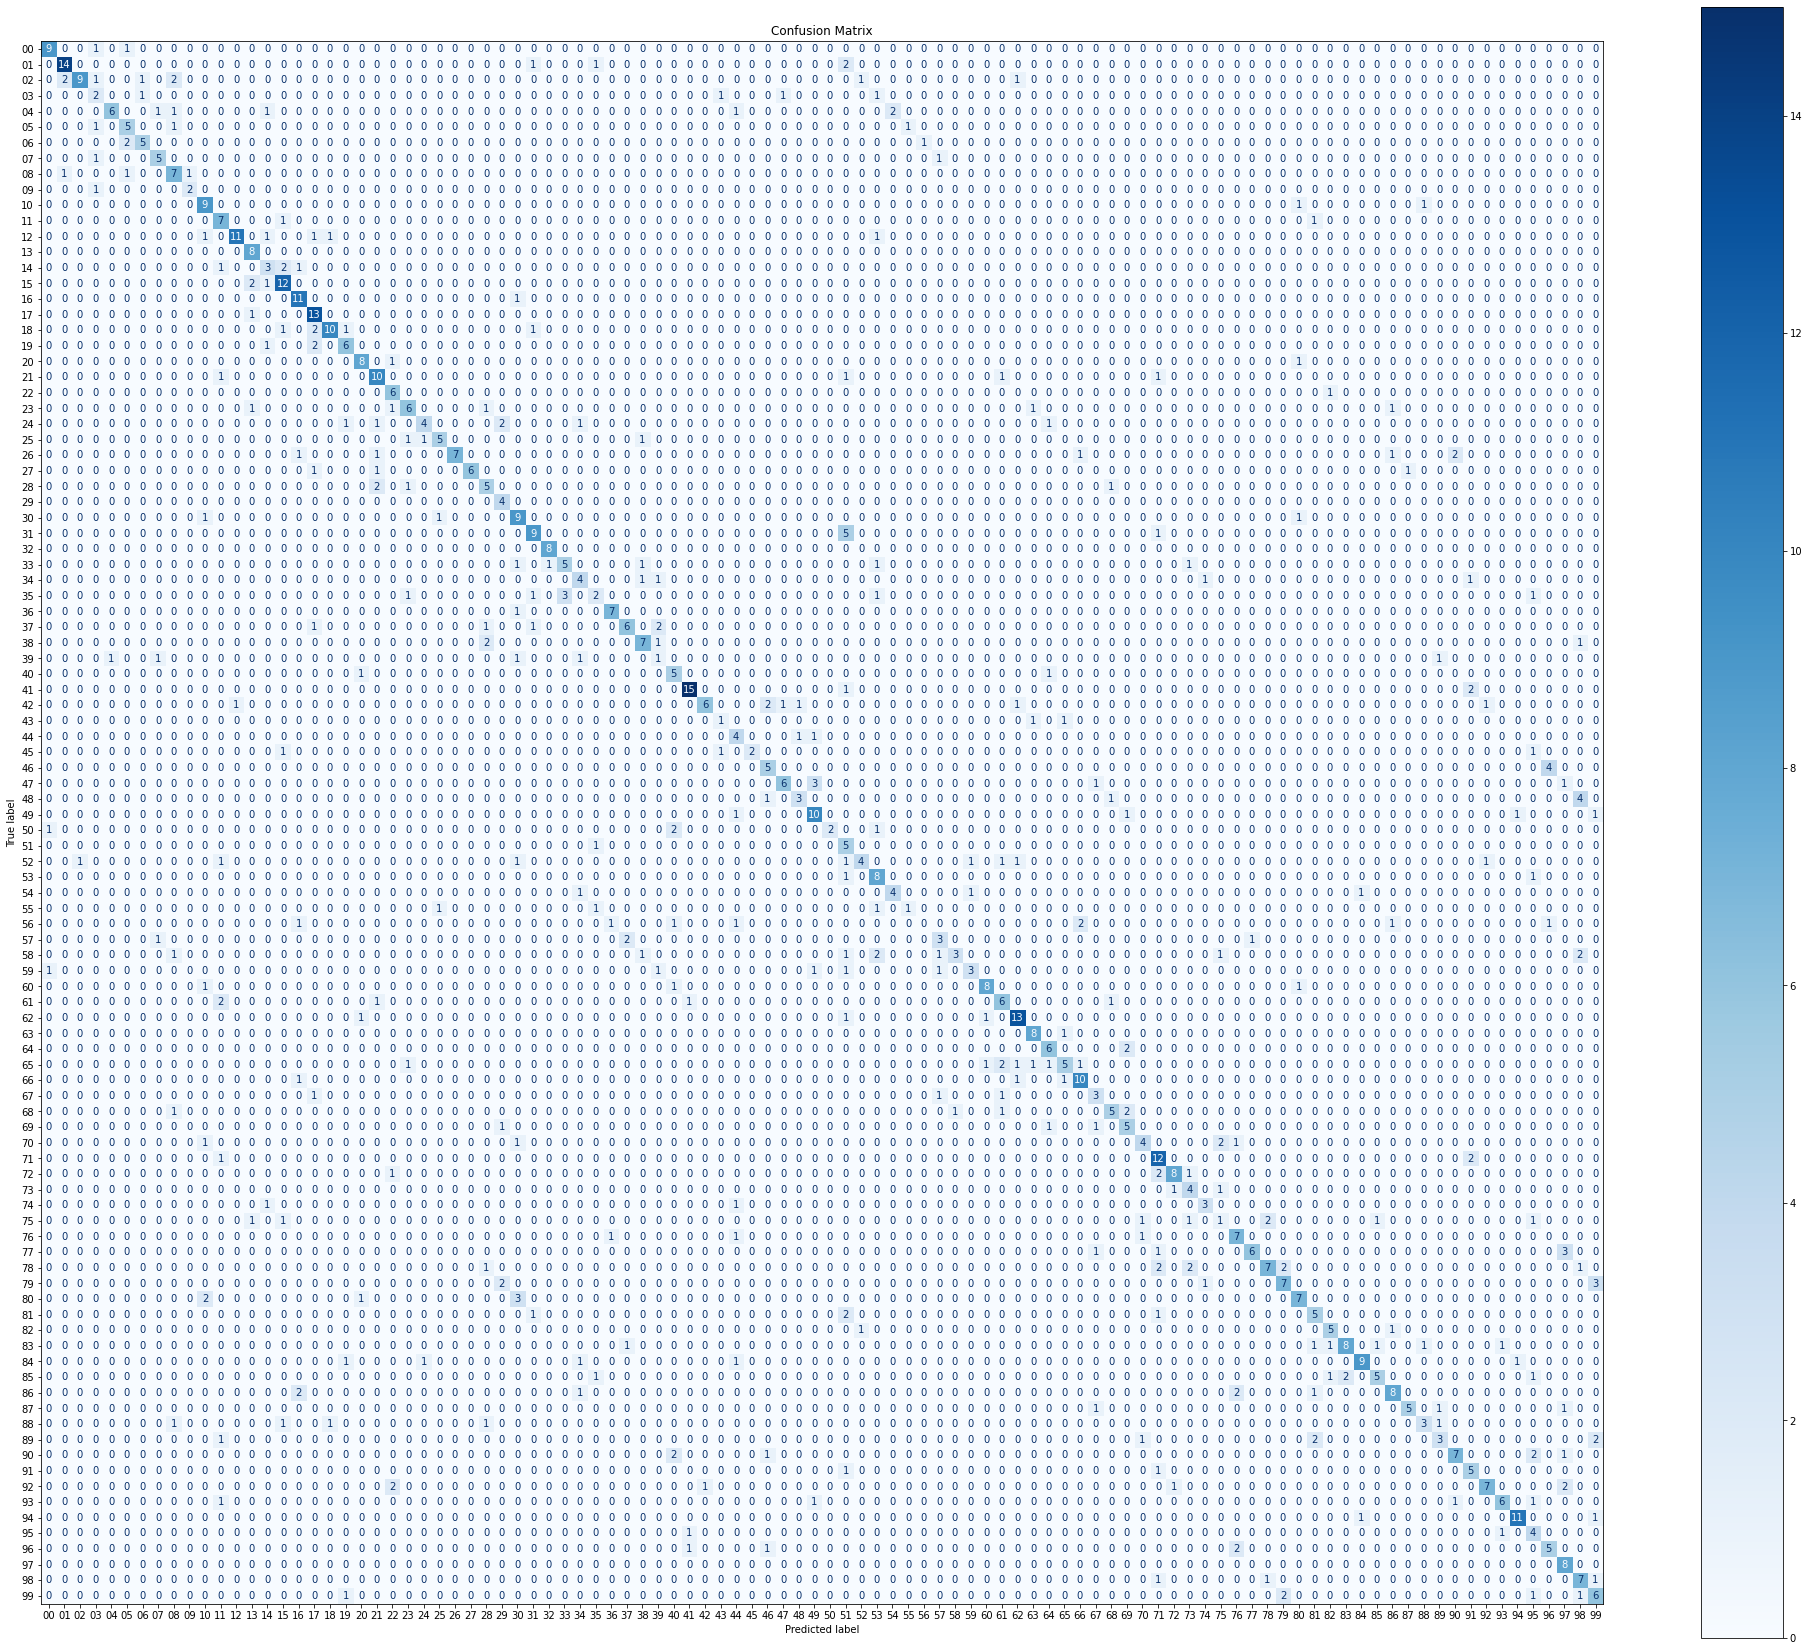

In [15]:
plot_cm(svm_test_generator, y_hat);

## CNN Classifier

In [16]:
train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="sparse",
    shuffle=True,
    seed=1234,
)

test_generator = datagen.flow_from_directory( 
    TEST_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="sparse",
    shuffle=False,
)

Found 10000 images belonging to 100 classes.
Found 1000 images belonging to 100 classes.


In [17]:
model = ResNetLike()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45, 45, 1)]       0         
_________________________________________________________________
res_block (ResBlock)         (None, 22, 22, 64)        28640     
_________________________________________________________________
res_block_1 (ResBlock)       (None, 11, 11, 256)       526976    
_________________________________________________________________
res_block_2 (ResBlock)       (None, 5, 5, 512)         1839744   
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5,
                                                 monitor='val_loss',
                                                 restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience=5, min_lr=0.001,),]

In [20]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps= test_generator.samples // BATCH_SIZE,
                    callbacks=my_callbacks,
                    verbose=2,
                    )

Epoch 1/50
78/78 - 5s - loss: 4.5211 - accuracy: 0.0293 - val_loss: 4.8302 - val_accuracy: 0.0100
Epoch 2/50
78/78 - 3s - loss: 3.9893 - accuracy: 0.0864 - val_loss: 8.1886 - val_accuracy: 0.0100
Epoch 3/50
78/78 - 3s - loss: 3.2057 - accuracy: 0.2007 - val_loss: 8.3811 - val_accuracy: 0.0112
Epoch 4/50
78/78 - 3s - loss: 2.3599 - accuracy: 0.3650 - val_loss: 4.5076 - val_accuracy: 0.0279
Epoch 5/50
78/78 - 3s - loss: 1.6425 - accuracy: 0.5551 - val_loss: 3.5806 - val_accuracy: 0.1239
Epoch 6/50
78/78 - 3s - loss: 1.1194 - accuracy: 0.7056 - val_loss: 1.6726 - val_accuracy: 0.6429
Epoch 7/50
78/78 - 3s - loss: 0.7965 - accuracy: 0.7988 - val_loss: 1.0402 - val_accuracy: 0.7589
Epoch 8/50
78/78 - 3s - loss: 0.6127 - accuracy: 0.8414 - val_loss: 0.5721 - val_accuracy: 0.8728
Epoch 9/50
78/78 - 3s - loss: 0.4694 - accuracy: 0.8849 - val_loss: 0.3620 - val_accuracy: 0.9129
Epoch 10/50
78/78 - 3s - loss: 0.3864 - accuracy: 0.9044 - val_loss: 0.3020 - val_accuracy: 0.9286
Epoch 11/50
78/78 -

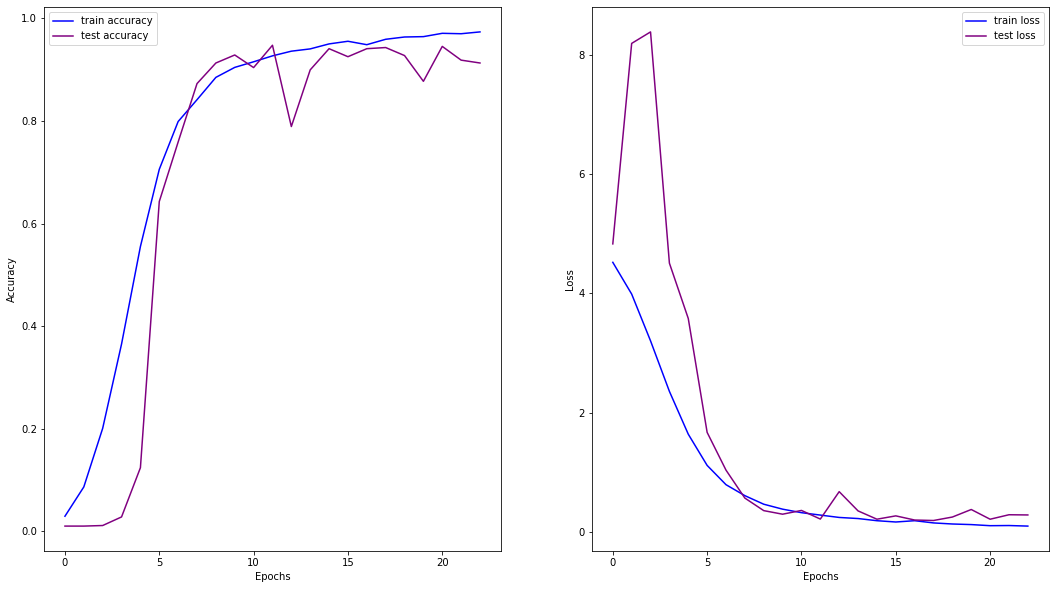

In [21]:
acc_loss_plot(history)

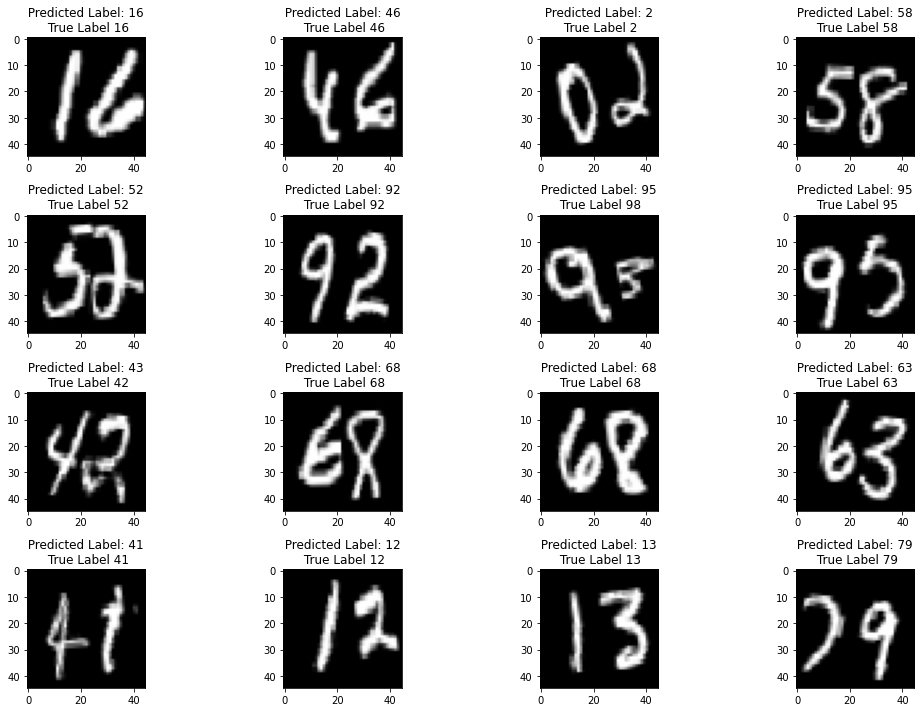

In [23]:
plot_mnist_images(eval_generator_one, model, row=4, col=4)

In [24]:
Y_pred = model.predict_generator(test_generator, test_generator.samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

In [25]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        17
           3       0.86      1.00      0.92         6
           4       1.00      0.92      0.96        12
           5       0.88      0.88      0.88         8
           6       1.00      1.00      1.00         8
           7       0.88      1.00      0.93         7
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         3
          10       0.91      0.91      0.91        11
          11       0.82      1.00      0.90         9
          12       0.94      1.00      0.97        16
          13       1.00      1.00      1.00         8
          14       0.88      1.00      0.93         7
          15       0.94      1.00      0.97        15
          16       0.92      0.92      0.92        12
          17       1.00    

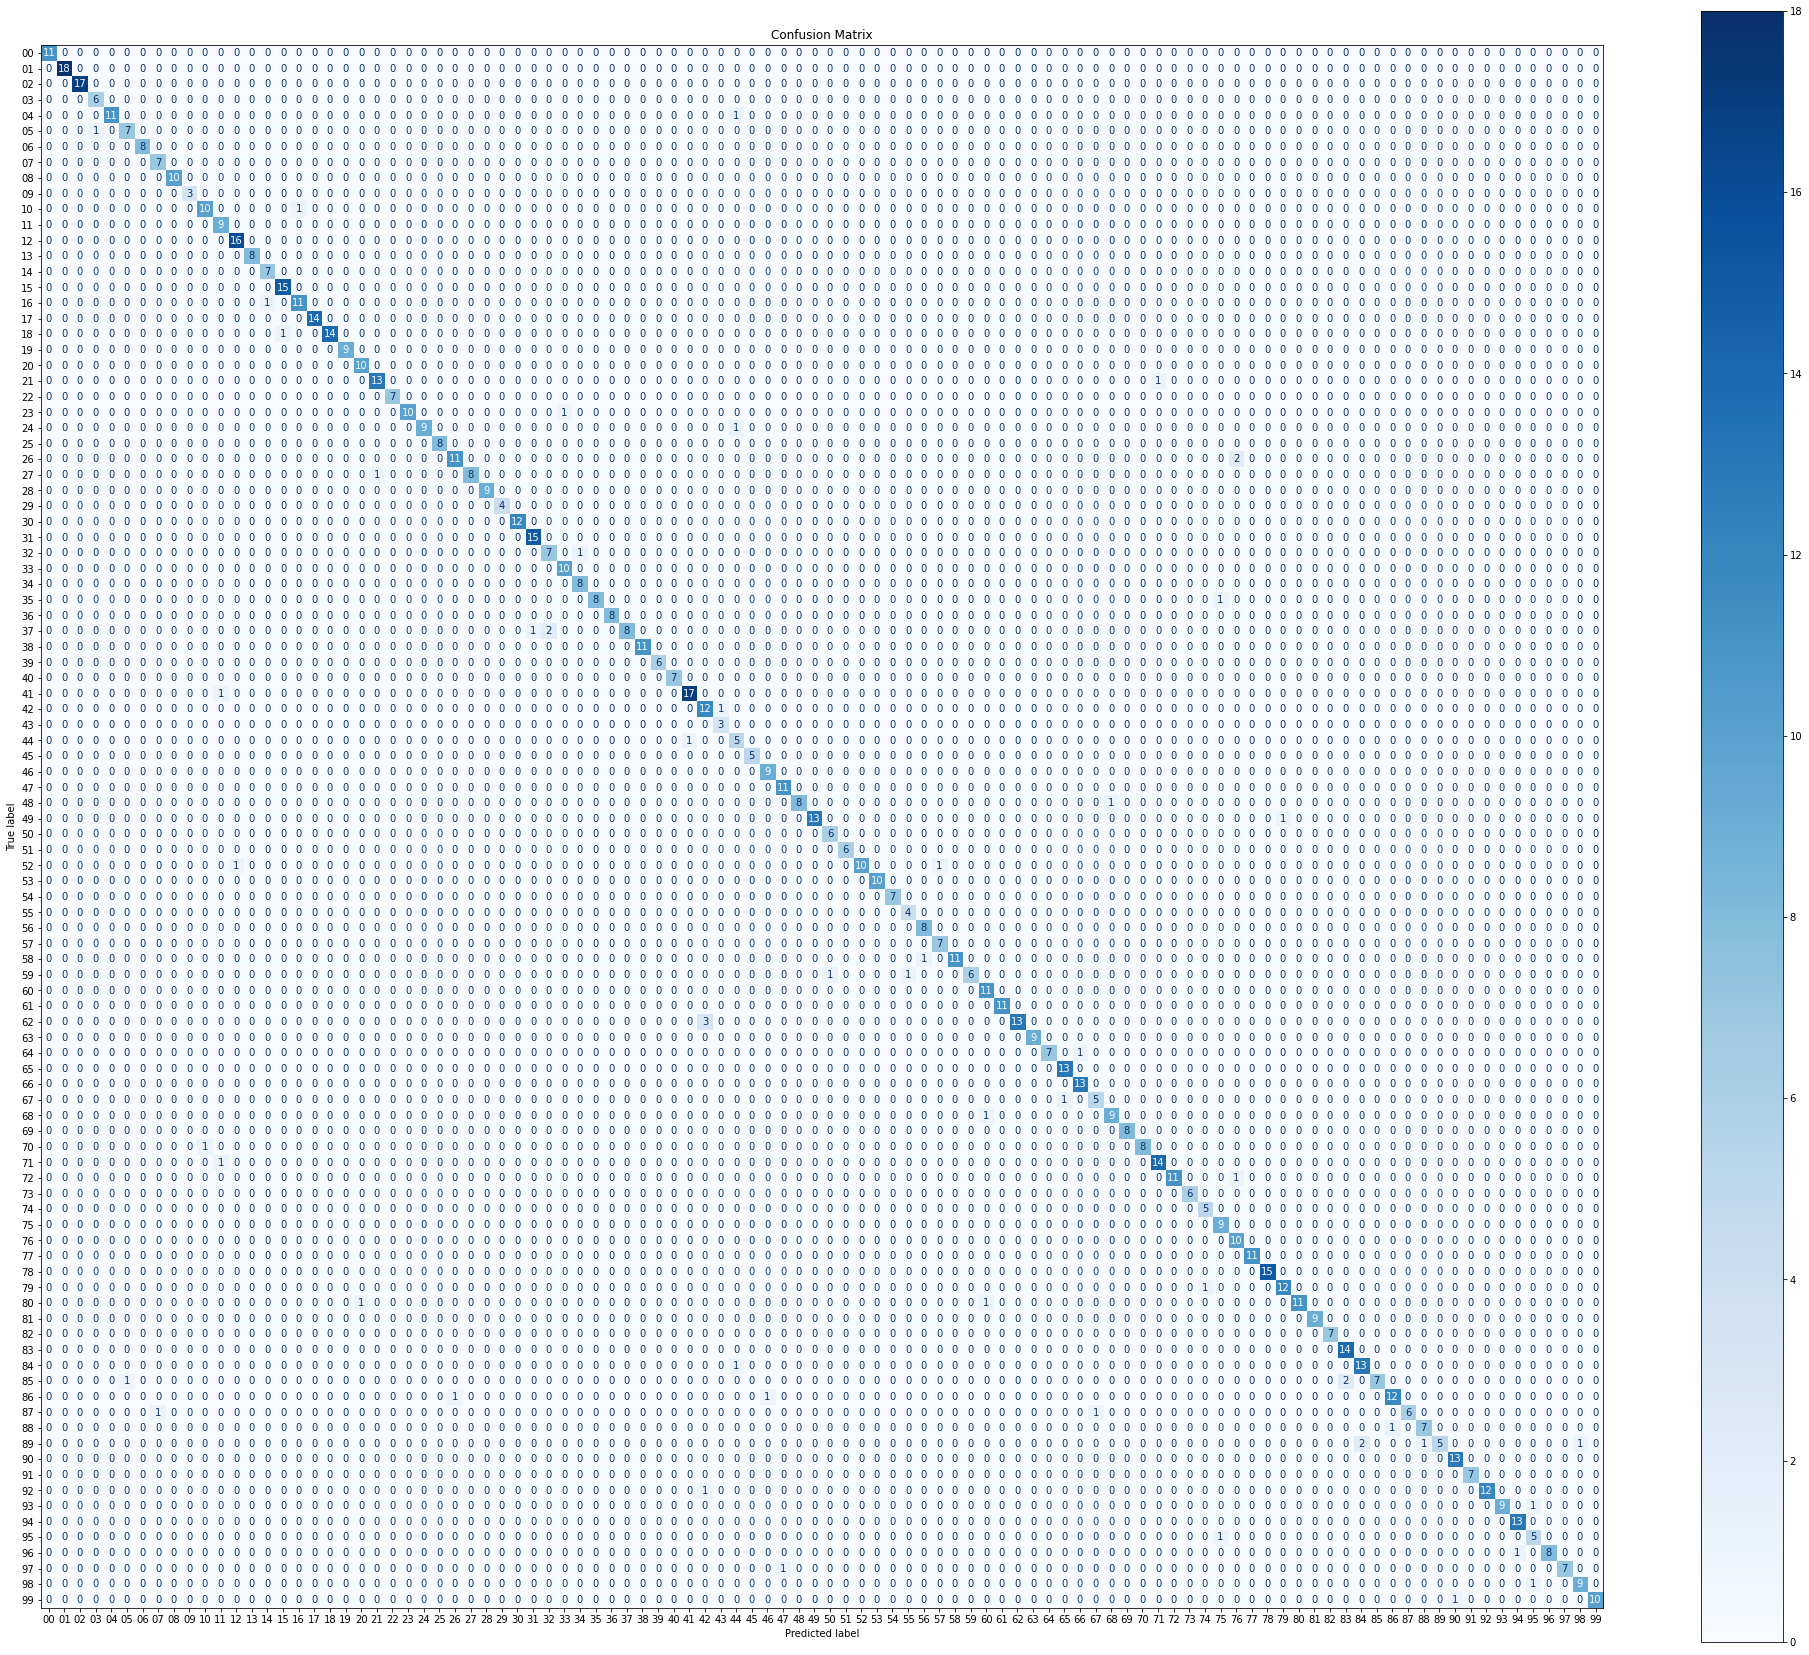

In [26]:
plot_cm(test_generator, y_pred);